
for intensity in ['low', 'medium', 'high']:
    for curve in ['straight', 'big']:
        time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & 
                                         (expected_ds['curvature'] == curve), drop=True).time.values
        
        if len(time_selection) > 0:
            # Compare different datasets
            datasets = [dsMC_low, dsMC_com]
            names = ['Low-cost', 'Commercial']
            colors = ['#1f77b4', '#ff7f0e']
            
            print(f"\n=== {intensity.title()} Intensity, {curve.title()} Curvature ===")
            fig = create_boxplot_comparison(datasets, names, intensity, curve, 
                                          time_selection[0], colors=colors)
            plt.show()
            
        # Only show first example to avoid too much output
        break
    break

In [27]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
import pandas as pd
import seaborn as sns
from scipy.stats import binned_statistic
import warnings
from soilgasflux_fcs import pareto

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data_v4/')

test_number = 7
test_number_base = 5
test_number_com = 6
normalizationType = 'no' #['no', 'len', 'yRange']
# add_info = '_ln_v2test4' #['', '_ln_v2', '_ln_v2test0]
add_info = '_test5'

filename_regular = f'test{test_number:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_base_regular = f'test{test_number_base:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_com_regular = f'test{test_number_com:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'

filename_mc = f'test{test_number:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_mc_com = f'test{test_number_com:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_mc_base = f'test{test_number_base:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'

filename_expected = f'expected_test{test_number:02}_2025-05-08.nc'

print(filename_regular)
print(filename_base_regular)
print(filename_mc)
print(filename_expected)

ds_low = xr.open_dataset(processed_data_path / filename_regular)
ds_base = xr.open_dataset(processed_data_path / filename_base_regular)
ds_com = xr.open_dataset(processed_data_path / filename_com_regular)

dsMC_low = xr.open_dataset(processed_data_path / filename_mc)
dsMC_com = xr.open_dataset(processed_data_path / filename_mc_com)
dsMC_base = xr.open_dataset(processed_data_path / filename_mc_base)

expected_ds = xr.open_dataset(processed_data_path / filename_expected)

test07_noNorm_test5_2025-05-08.nc
test05_noNorm_test5_2025-05-08.nc
test07_MC_noNorm_test5_2025-05-08.nc
expected_test07_2025-05-08.nc


In [29]:
test_a = expected_ds.isel(cutoff=0)['dcdt(HM)'].values
binned_statistic(test_a, test_a, bins=3)[2]
# Define your intensity categories
intensity_labels = ['low', 'medium', 'high']

# Calculate bin indices (0, 1, or 2)
bin_indices = binned_statistic(test_a, test_a, bins=3)[2] - 1  # -1 because bins are 1-indexed

# Map indices to labels
intensity_categories = np.array(intensity_labels)[bin_indices]
group_intensity = xr.DataArray(
    intensity_categories,
    coords={'time': expected_ds['time']},
    dims=['time']
)

expected_ds = expected_ds.assign_coords(intensity_categories=group_intensity)

In [30]:
def find_pareto_front(x, y, maximize_x=False, maximize_y=False):
    """
    Find the Pareto front for two objectives
    
    Parameters:
    -----------
    x, y : array-like
        Values of the two objectives
    maximize_x, maximize_y : bool
        Whether to maximize (True) or minimize (False) each objective
    
    Returns:
    --------
    pareto_indices : ndarray
        Indices of points on the Pareto front
    """
    import numpy as np
    
    # Copy arrays to avoid modifying originals
    x_values = np.copy(x)
    y_values = np.copy(y)
    
    # Convert maximization to minimization
    if maximize_x:
        x_values = -x_values
    if maximize_y:
        y_values = -y_values
    
    points = np.column_stack((x_values, y_values))
    pareto_indices = []
    
    for i, point in enumerate(points):
        if np.isnan(point).any():
            continue
            
        dominated = False
        for j, other_point in enumerate(points):
            if i != j and not np.isnan(other_point).any():
                # Check if other_point dominates point (smaller is better)
                if (all(other_point <= point) and any(other_point < point)):
                    dominated = True
                    break
        
        if not dominated:
            pareto_indices.append(i)
    
    return np.array(pareto_indices)


big
low


IndexError: index 6 is out of bounds for axis 0 with size 6

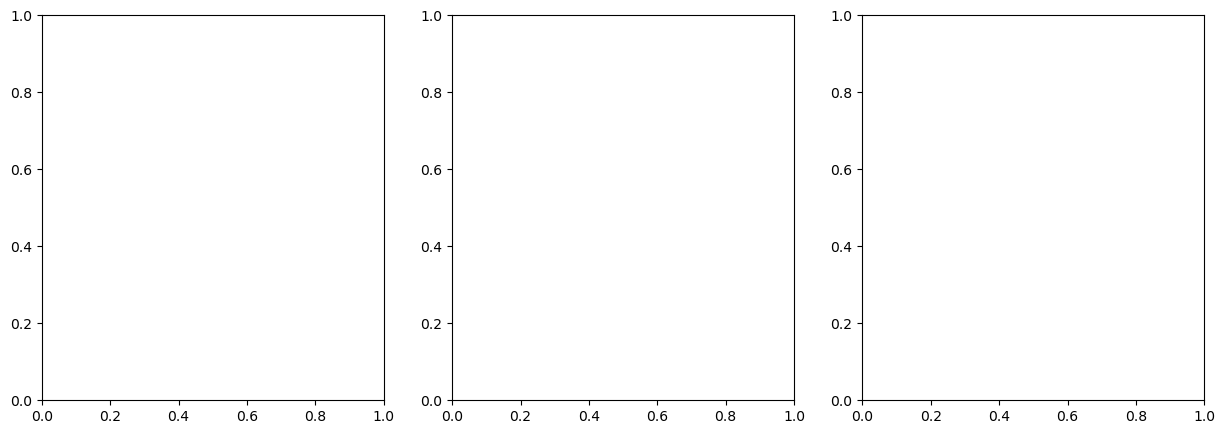

In [31]:
for curve in np.unique(expected_ds['curvature'].values):
    print(curve)
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for n, intensity in enumerate(['low', 'medium', 'high']):
        print(intensity)
        time_selection = expected_ds.where((expected_ds['curvature'] == curve) &
                                           (expected_ds['intensity_categories'] == intensity),
                                           drop=True)['time'].values
        ######################################################################
        datasets = [dsMC_com, dsMC_low]
        datasets_types = ['Commercial', 'Low-cost']
        for dsMC, dataset_type in zip(datasets, datasets_types):

            mc_hm = dsMC.sel(time=time_selection).median(dim=['MC','time'])['dcdt(HM)']
            uncertaintyRange_hm = dsMC.sel(time=time_selection).quantile(0.84, dim=['MC','time'])['dcdt(HM)']-dsMC.sel(time=time_selection).quantile(0.16, dim=['MC','time'])['dcdt(HM)']      
            logprob_hm = -dsMC.sel(time=time_selection).median(dim=['MC','time'])['logprob(HM)']

            Norm_uncertaintyRange = (uncertaintyRange_hm.values - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
            Norm_logprob = (logprob_hm.values - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
            
            flatNorm_uncertaintyRange = (uncertaintyRange_hm.values.flatten() - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
            flatNorm_logprob = (logprob_hm.values.flatten() - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))

            # Find Pareto front
            pareto_uncertaintyRange_logprob = find_pareto_front(x=flatNorm_uncertaintyRange, 
                                                                y=flatNorm_logprob, 
                                                                maximize_x=False, maximize_y=False)
            coords_pareto_uncertaintyRange_logprob = np.unravel_index(pareto_uncertaintyRange_logprob, uncertaintyRange_hm.shape)
            distance_pareto_uncertaintyRange_logprob = np.sqrt((Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob])**2 + 
                                                            (Norm_logprob[coords_pareto_uncertaintyRange_logprob])**2)
            # argmin_distance_pareto_uncertaintyRange_logprob = np.unravel_index(np.argmin(distance_pareto_uncertaintyRange_logprob), uncertaintyRange_hm.shape)
            argmin_distance_pareto_uncertaintyRange_logprob = np.nanargmin(distance_pareto_uncertaintyRange_logprob)
            
            best_pareto_x = coords_pareto_uncertaintyRange_logprob[0][argmin_distance_pareto_uncertaintyRange_logprob]
            best_pareto_y = coords_pareto_uncertaintyRange_logprob[1][argmin_distance_pareto_uncertaintyRange_logprob]

            hist_dcdt = dsMC.sel(time=time_selection,
                                cutoff=cutoff_coords[best_pareto_y], 
                                deadband=deadband_coords[best_pareto_x])['dcdt(HM)']
            ######################################################################

        arbitrary_results = {'deadband':[10,30, 30,50,50],
                                'cutoff':[70,120,170,120,170],  
                                'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}
        # ax[0].bar([0], [hist_dcdt.median().values],
        #             # yerr=hist_dcdt.quantile(0.84).values - hist_dcdt.quantile(0.16).values,
        #             yerr=[(hist_dcdt.quantile(0.84).values-hist_dcdt.median().values),
        #                   (hist_dcdt.median().values-hist_dcdt.quantile(0.16).values)],
        #             label=intensity, alpha=0.5, width=0.2, 
        #             # color=models.intensity_colors[intensity]
        #             )
        ax[n].bar([f'{intensity} (Low-cost)'], [hist_dcdt.median().values],
            yerr=np.array([[hist_dcdt.median().values-hist_dcdt.quantile(0.16).values],
                            [hist_dcdt.quantile(0.84).values-hist_dcdt.median().values]]),
            # yerr= np.array([[10],[20]]),
            label=intensity, alpha=0.5, width=0.1)
        

        
        
        ### Arbitrary results from base
        ax[n].axhline(y=ds_base.sel(time=time_selection,
                                    deadband=0, cutoff=60)['dcdt(HM)'].median().values, 
                                    color='red', linestyle='-', linewidth=1)
        ax[n].axhline(y=ds_base.sel(time=time_selection,
                                    deadband=20, cutoff=120)['dcdt(HM)'].median().values, 
                                    color='blue', linestyle='-', linewidth=1)
        ax[n].axhline(y=ds_base.sel(time=time_selection,
                                    deadband=20, cutoff=170)['dcdt(HM)'].median().values, 
                                    color='blue', linestyle='-', linewidth=1)
        
        fig.suptitle(f'Curvature {curve}')
        
        # break
    # break



In [32]:
dsMC_com

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 30, cutoff: 12, deadband: 6, MC: 15000)
Coordinates:
  * time           (time) datetime64[ns] 240B 2025-05-08T15:22:56 ... 2025-05...
  * deadband       (deadband) int64 48B 0 10 20 30 40 50
  * cutoff         (cutoff) int64 96B 60 70 80 90 100 ... 130 140 150 160 170
  * MC             (MC) int64 120kB 0 1 2 3 4 ... 14995 14996 14997 14998 14999
Data variables:
    dcdt(HM)       (time, cutoff, deadband, MC) float32 130MB ...
    dcdt(linear)   (time, cutoff, deadband, MC) float32 130MB ...
    AIC(HM)        (time, cutoff, deadband, MC) float32 130MB ...
    AIC(linear)    (time, cutoff, deadband, MC) float32 130MB ...
    RMSE(HM)       (time, cutoff, deadband, MC) float32 130MB ...
    RMSE(linear)   (time, cutoff, deadband, MC) float32 130MB ...
    R2(HM)         (time, cutoff, deadband, MC) float32 130MB ...
    R2(linear)     (time, cutoff, deadband, MC) float32 130MB ...
    nRMSE(HM)      (time, cutoff, deadband, MC) float32 130MB ...
    nRMSE(linear)  (time, cutoff, deadband, MC) float32 130MB ...
    logprob(HM)    (time, cutoff, deadband, MC) float32 130MB ...


big
low
	Dataset type: Low-cost
	Best Pareto x: 7, y: 4
		Deadband: 40
		Cutoff: 130
[0.03922379 0.03927363 0.03972427 ... 0.15625724 0.1629341  0.16309519]
	Dataset type: Commercial
	Best Pareto x: 7, y: 4
		Deadband: 40
		Cutoff: 130
[0.03922379 0.03927363 0.03972427 ... 0.15625724 0.1629341  0.16309519]
	Dataset type: Commercial
	Best Pareto x: 6, y: 3
		Deadband: 30
		Cutoff: 120
[0.0384245  0.03857575 0.03869575 ... 0.16449602 0.16512765 0.17252344]
medium
	Dataset type: Low-cost
	Best Pareto x: 6, y: 3
		Deadband: 30
		Cutoff: 120
[0.0384245  0.03857575 0.03869575 ... 0.16449602 0.16512765 0.17252344]
medium
	Dataset type: Low-cost
	Best Pareto x: 6, y: 4
		Deadband: 40
		Cutoff: 120
[0.4701495  0.47039744 0.47391132 ... 0.7737057  0.77750754 0.7789871 ]
	Dataset type: Commercial
	Best Pareto x: 6, y: 4
		Deadband: 40
		Cutoff: 120
[0.4701495  0.47039744 0.47391132 ... 0.7737057  0.77750754 0.7789871 ]
	Dataset type: Commercial
	Best Pareto x: 4, y: 2
		Deadband: 20
		Cutoff: 10

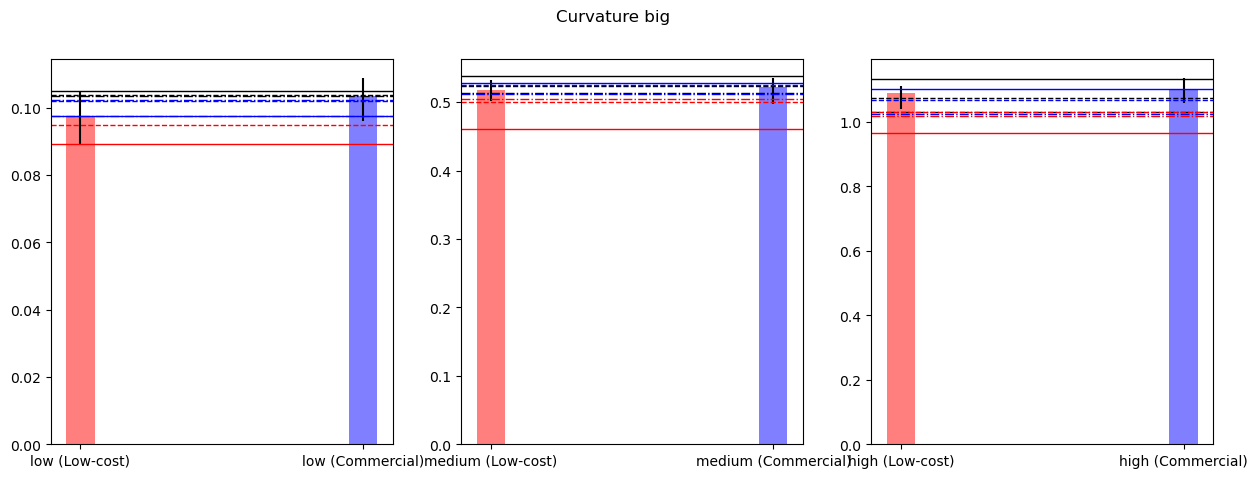

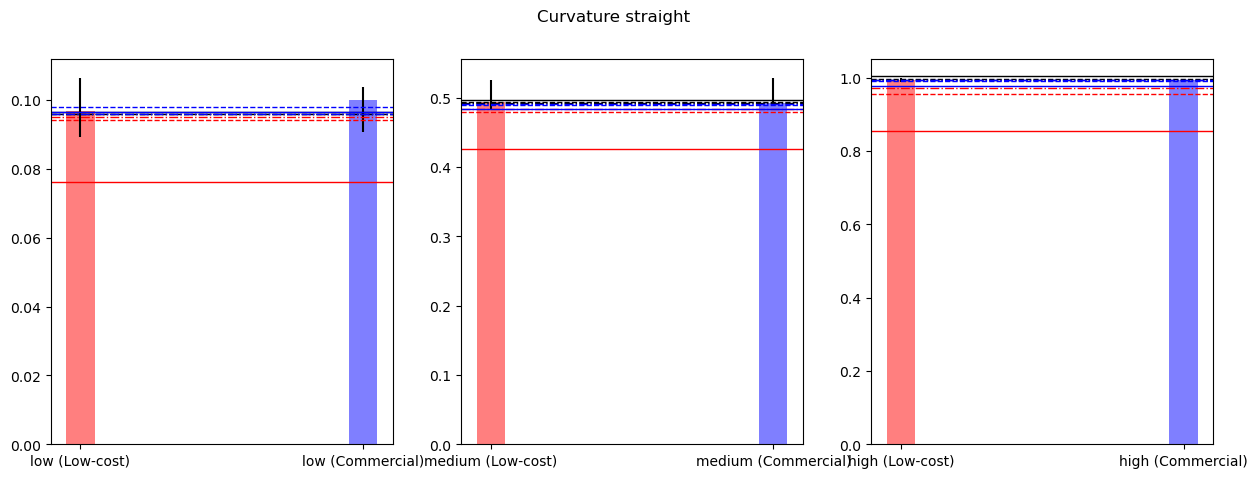

In [33]:
for curve in np.unique(expected_ds['curvature'].values):
    print()
    print(curve)
    cutoff_coords, deadband_coords = ds_base.coords['cutoff'], ds_base.coords['deadband']
    # print(cutoff_coords, deadband_coords)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for n, intensity in enumerate(['low', 'medium', 'high']):
        print(intensity)
        time_selection = expected_ds.where((expected_ds['curvature'] == curve) &
                                           (expected_ds['intensity_categories'] == intensity),
                                           drop=True).time.values
        
        datasets = [dsMC_low,dsMC_com]
        datasets_types = ['Low-cost', 'Commercial']
        colors = ['black', 'red', 'blue']

        for i,(dsMC, dataset_type) in enumerate(zip(datasets, datasets_types)):
            # print(dsMC.sel(time=time_selection))
            print('\tDataset type:', dataset_type)
            ######################################################################
            pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection).median(dim=['time']))
            Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange,flatNorm_logprob = pa.prepare_metrics()
            mc_hm = dsMC.sel(time=time_selection).median(dim=['time'], skipna=True)['dcdt(HM)']
            # print(mc_hm)

            pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                y=flatNorm_logprob, 
                                                                maximize_x=False, maximize_y=False)
            best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob,
                                                                metric_x=Norm_uncertaintyRange,
                                                                metric_y=Norm_logprob)
            print(f'\tBest Pareto x: {best_pareto_x}, y: {best_pareto_y}')
            print('\t\tDeadband:', deadband_coords[best_pareto_y].values)
            print('\t\tCutoff:', cutoff_coords[best_pareto_x].values)
            hist_dcdt = dsMC.sel(time=time_selection,
                                deadband=deadband_coords[best_pareto_y].values,
                                cutoff=cutoff_coords[best_pareto_x].values, 
                                )['dcdt(HM)']
            # print('\t\tdcdt median:', hist_dcdt.nanmedian().values)
            print(np.unique(hist_dcdt.values))

            ax[n].bar([f'{intensity} ({dataset_type})'], [hist_dcdt.median().values],
                yerr=np.array([[hist_dcdt.median().values-hist_dcdt.quantile(0.16).values],
                                [hist_dcdt.quantile(0.84).values-hist_dcdt.median().values]]),
                label=intensity, alpha=0.5, width=0.1, color=colors[i+1])
            ######################################################################

        
        
        arbitrary_results = {'deadband':[10,30, 30,50,50],
                                'cutoff':[70,120,170,120,170],  
                                'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}
        
        datasets = [ds_base, dsMC_low, dsMC_com]
        datasets_types = ['Base', 'Low-cost', 'Commercial']
        for i,(ds, dataset_type) in enumerate(zip(datasets, datasets_types)):
            
            
            ### Arbitrary results from base
            ax[n].axhline(y=ds.sel(time=time_selection,
                                        deadband=0, cutoff=60)['dcdt(HM)'].median().values, 
                                        color=colors[i], linestyle='-', linewidth=1)
            ax[n].axhline(y=ds.sel(time=time_selection,
                                        deadband=0, cutoff=120)['dcdt(HM)'].median().values, 
                                        color=colors[i], linestyle='--', linewidth=1)
            ax[n].axhline(y=ds.sel(time=time_selection,
                                        deadband=0, cutoff=170)['dcdt(HM)'].median().values, 
                                        color=colors[i], linestyle='-.', linewidth=1)
        
        fig.suptitle(f'Curvature {curve}')
        
        # break
    # break




big
low
['2025-05-08T15:22:56.000000000' '2025-05-08T15:28:56.000000000'
 '2025-05-08T15:34:56.000000000' '2025-05-08T15:40:56.000000000'
 '2025-05-08T15:46:56.000000000']


	Best Pareto x: 7, y: 4
		Deadband: 40
		Cutoff: 130
		dcdt median: 0.09769208
	Best Pareto x: 6, y: 3
		Deadband: 30
		Cutoff: 120
		dcdt median: 0.10345621
medium
['2025-05-08T15:52:56.000000000' '2025-05-08T15:58:56.000000000'
 '2025-05-08T16:04:56.000000000' '2025-05-08T16:10:56.000000000'
 '2025-05-08T16:16:56.000000000']
	Best Pareto x: 6, y: 3
		Deadband: 30
		Cutoff: 120
		dcdt median: 0.10345621
medium
['2025-05-08T15:52:56.000000000' '2025-05-08T15:58:56.000000000'
 '2025-05-08T16:04:56.000000000' '2025-05-08T16:10:56.000000000'
 '2025-05-08T16:16:56.000000000']
	Best Pareto x: 6, y: 4
		Deadband: 40
		Cutoff: 120
		dcdt median: 0.5175743
	Best Pareto x: 6, y: 4
		Deadband: 40
		Cutoff: 120
		dcdt median: 0.5175743
	Best Pareto x: 4, y: 2
		Deadband: 20
		Cutoff: 100
		dcdt median: 0.5218991
high
['2025-05-08T16:22:56.000000000' '2025-05-08T16:28:56.000000000'
 '2025-05-08T16:34:56.000000000' '2025-05-08T16:40:56.000000000'
 '2025-05-08T16:46:56.000000000']
	Best Pareto x: 4,

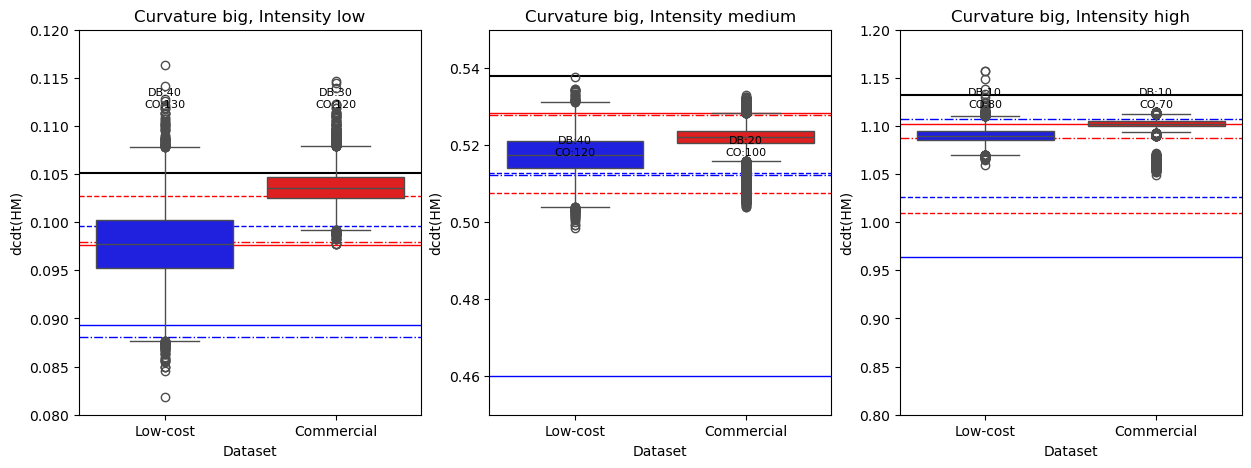

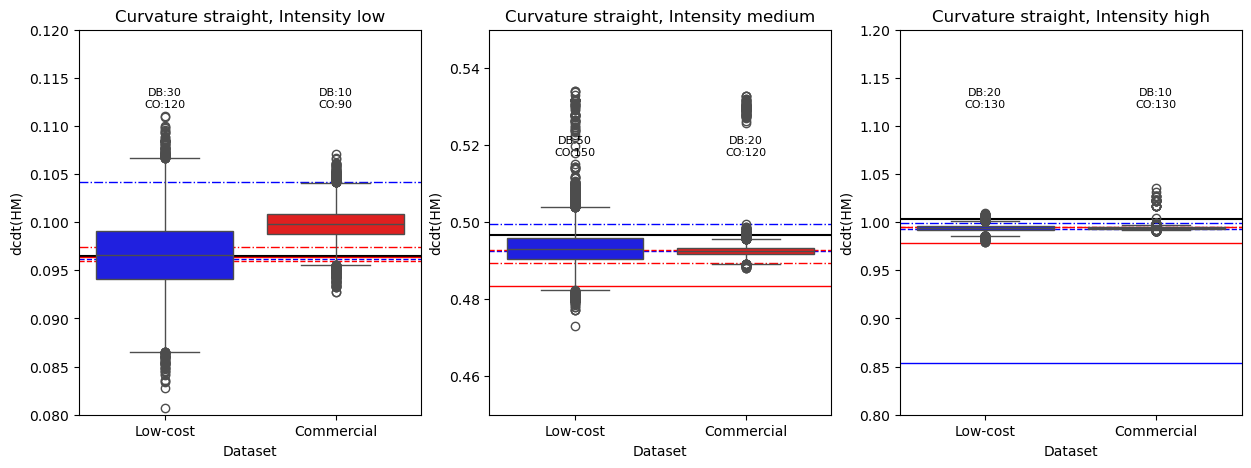

In [34]:
datasets = [dsMC_low, dsMC_com]
datasets_types = ['Low-cost', 'Commercial']
colors = ['blue', 'red']
# for i, (ds, dataset_type) in enumerate(zip(datasets, datasets_types)):
#     print(dataset_type)

for curve in np.unique(expected_ds['curvature'].values):
    print()
    print(curve)
    cutoff_coords, deadband_coords = ds_base.coords['cutoff'], ds_base.coords['deadband']
    # print(cutoff_coords, deadband_coords)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    yRange = [(0.08, 0.12), (0.45, 0.55), (0.8, 1.2)]
    for n, intensity in enumerate(['low', 'medium', 'high']):
        print(intensity)
        time_selection = expected_ds.where((expected_ds['curvature'] == curve) &
                                           (expected_ds['intensity_categories'] == intensity),
                                           drop=True).time.values
        print(time_selection)
        ax[n].axhline(ds_base.sel(time=time_selection,
                                            deadband=0, cutoff=60)['dcdt(HM)'].median().values,
                                            label='Base', color='black')
        
        ax[n].set_title(f'Curvature {curve}, Intensity {intensity}')

        # Collect data for both datasets
        df_boxplot = pd.DataFrame()
        
        for i, (dsMC, dataset_type) in enumerate(zip(datasets, datasets_types)):
            ######################################################################
            pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection).median(dim=['time']))
            Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange,flatNorm_logprob = pa.prepare_metrics()
            mc_hm = dsMC.sel(time=time_selection).median(dim=['time'], skipna=True)['dcdt(HM)']

            pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                y=flatNorm_logprob, 
                                                                maximize_x=False, maximize_y=False)
            best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob,
                                                                metric_x=Norm_uncertaintyRange,
                                                                metric_y=Norm_logprob)
            print(f'\tBest Pareto x: {best_pareto_x}, y: {best_pareto_y}')
            print('\t\tDeadband:', deadband_coords[best_pareto_y].values)
            print('\t\tCutoff:', cutoff_coords[best_pareto_x].values)
            
            hist_dcdt = dsMC.sel(time=time_selection,
                                deadband=deadband_coords[best_pareto_y].values,
                                cutoff=cutoff_coords[best_pareto_x].values, 
                                )['dcdt(HM)']
            print('\t\tdcdt median:', hist_dcdt.median().values)
            
            # Create DataFrame for this dataset
            temp_df = pd.DataFrame({
                'dcdt(HM)': hist_dcdt.median(dim='time').values.flatten(),
                'Dataset': dataset_type,
                'Deadband': deadband_coords[best_pareto_y].values,
                'Cutoff': cutoff_coords[best_pareto_x].values
            })
            df_boxplot = pd.concat([df_boxplot, temp_df], ignore_index=True)
            ax[n].axhline(y=dsMC.sel(time=time_selection,
                                     deadband=0, cutoff=60)['dcdt(HM)'].median().values,
                                     color=colors[i], linestyle='-', linewidth=1, label=dataset_type)
            ax[n].axhline(y=dsMC.sel(time=time_selection,
                                     deadband=20, cutoff=170)['dcdt(HM)'].median().values,
                                     color=colors[i], linestyle='--', linewidth=1)
            ax[n].axhline(y=dsMC.sel(time=time_selection,
                                     deadband=20, cutoff=80)['dcdt(HM)'].median().values,
                                     color=colors[i], linestyle='-.', linewidth=1)
            
            
        # Create boxplot with two categories
        sns.boxplot(data=df_boxplot, x='Dataset', y='dcdt(HM)', 
                   palette=colors, ax=ax[n])
        
        # Add labels with deadband-cutoff info
        ax[n].set_ylim((yRange[n][0], yRange[n][1]))
        for i, dataset_type in enumerate(datasets_types):
            dataset_data = df_boxplot[df_boxplot['Dataset'] == dataset_type]
            if len(dataset_data) > 0:
                deadband_val = dataset_data['Deadband'].iloc[0]
                cutoff_val = dataset_data['Cutoff'].iloc[0]
                ax[n].text(i, ax[n].get_ylim()[1] * 0.95, 
                          f'DB:{deadband_val:.0f}\nCO:{cutoff_val:.0f}', 
                          ha='center', va='top', fontsize=8)


        # break

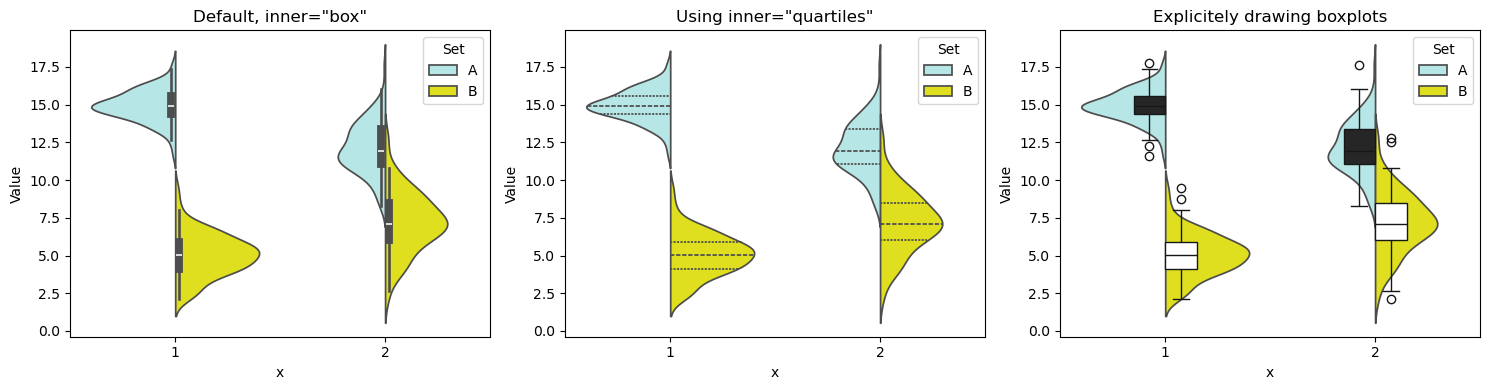

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

data = pd.DataFrame({'Value': (np.random.randn(4, 100).cumsum(axis=0) + np.array([[15], [5], [12], [7]])).ravel(),
                     'Set': np.repeat(['A', 'B', 'A', 'B'], 100),
                     'x': np.repeat([1, 2], 200)})
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))

palette = ['paleturquoise', 'yellow']
sns.violinplot(data=data, x='x', y='Value', hue='Set', split=True, inner='box', palette=palette, ax=ax1)
ax1.set_title('Default, inner="box"')

sns.violinplot(data=data, x='x', y='Value', hue='Set', split=True, inner='quartiles', palette=palette, ax=ax2)
ax2.set_title('Using inner="quartiles"')

sns.violinplot(data=data, x='x', y='Value', hue='Set', split=True, inner=None, palette=palette, ax=ax3)
sns.boxplot(data=data, x='x', y='Value', hue='Set', color='white', width=0.3, boxprops={'zorder': 2}, ax=ax3)
ax3.set_title('Explicitely drawing boxplots')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles[:2], labels[:2], title='Set')
plt.tight_layout()
plt.show()

In [36]:
cm = 1/2.54  # centimeters in inches


big
low
['2025-05-08T15:22:56.000000000' '2025-05-08T15:28:56.000000000'
 '2025-05-08T15:34:56.000000000' '2025-05-08T15:40:56.000000000'
 '2025-05-08T15:46:56.000000000']
	Best Pareto x: 7, y: 4
		Deadband: 40
		Cutoff: 130
		dcdt median: 0.09769208
	Best Pareto x: 7, y: 4
		Deadband: 40
		Cutoff: 130
		dcdt median: 0.09769208
	Best Pareto x: 6, y: 3
		Deadband: 30
		Cutoff: 120
		dcdt median: 0.10345621
medium
['2025-05-08T15:52:56.000000000' '2025-05-08T15:58:56.000000000'
 '2025-05-08T16:04:56.000000000' '2025-05-08T16:10:56.000000000'
 '2025-05-08T16:16:56.000000000']
	Best Pareto x: 6, y: 3
		Deadband: 30
		Cutoff: 120
		dcdt median: 0.10345621
medium
['2025-05-08T15:52:56.000000000' '2025-05-08T15:58:56.000000000'
 '2025-05-08T16:04:56.000000000' '2025-05-08T16:10:56.000000000'
 '2025-05-08T16:16:56.000000000']
	Best Pareto x: 6, y: 4
		Deadband: 40
		Cutoff: 120
		dcdt median: 0.5175743
	Best Pareto x: 6, y: 4
		Deadband: 40
		Cutoff: 120
		dcdt median: 0.5175743
	Best Pareto 

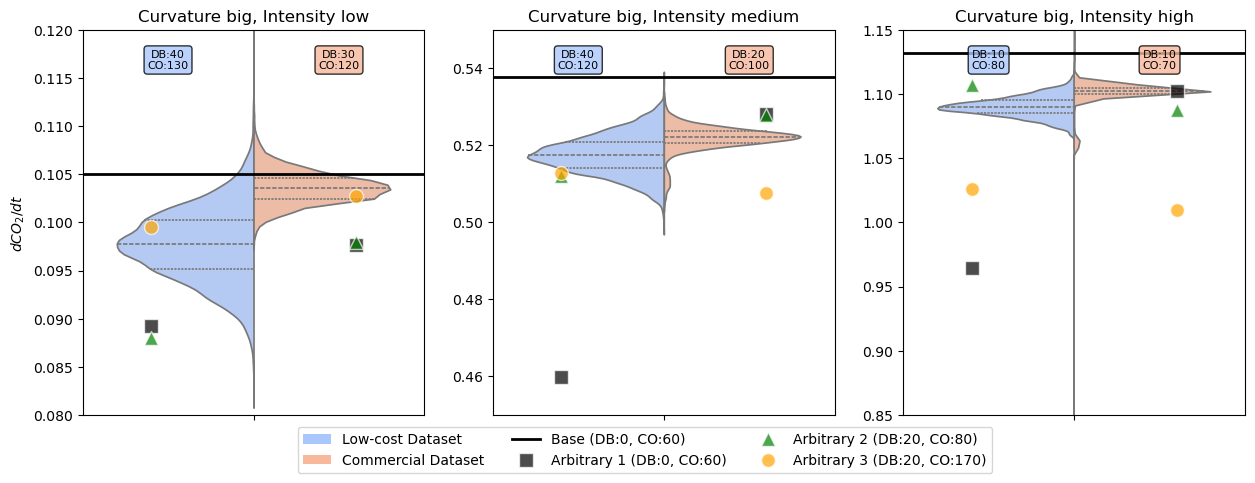

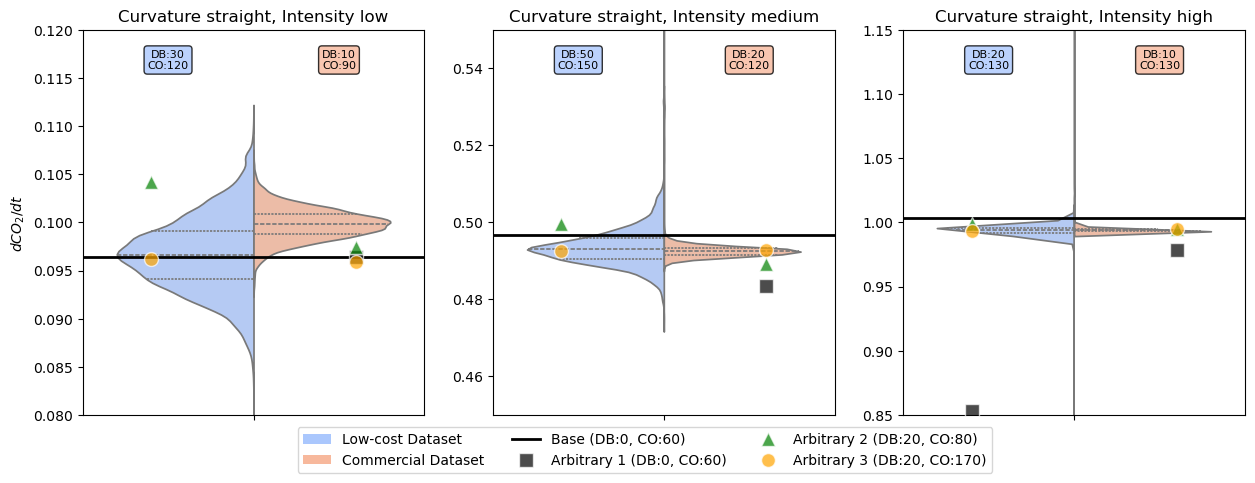

In [37]:
datasets = [dsMC_low, dsMC_com]
datasets_types = ['Low-cost', 'Commercial']
# colors = ['blue', 'red']
# for i, (ds, dataset_type) in enumerate(zip(datasets, datasets_types)):
#     print(dataset_type)

coolwarm_palette = sns.color_palette("coolwarm", n_colors=2)
colors = coolwarm_palette
for curve in np.unique(expected_ds['curvature'].values):
    print()
    print(curve)
    cutoff_coords, deadband_coords = ds_base.coords['cutoff'], ds_base.coords['deadband']
    # print(cutoff_coords, deadband_coords)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    yRange = [(0.08, 0.12), (0.45, 0.55), (0.85, 1.15)]
    for n, intensity in enumerate(['low', 'medium', 'high']):
        print(intensity)
        time_selection = expected_ds.where((expected_ds['curvature'] == curve) &
                                           (expected_ds['intensity_categories'] == intensity),
                                           drop=True).time.values
        print(time_selection)
        
        # Base line across full width
        ax[n].axhline(ds_base.sel(time=time_selection,
                                            deadband=0, cutoff=60)['dcdt(HM)'].median().values,
                                            label='Base', color='black', linewidth=2)
        
        ax[n].set_title(f'Curvature {curve}, Intensity {intensity}')

        # Collect data for both datasets
        df_boxplot = pd.DataFrame()
        
        for i, (dsMC, dataset_type) in enumerate(zip(datasets, datasets_types)):
            ######################################################################
            pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection).median(dim=['time']))
            Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange,flatNorm_logprob = pa.prepare_metrics()
            mc_hm = dsMC.sel(time=time_selection).median(dim=['time'], skipna=True)['dcdt(HM)']

            pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                y=flatNorm_logprob, 
                                                                maximize_x=False, maximize_y=False)
            best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob,
                                                                metric_x=Norm_uncertaintyRange,
                                                                metric_y=Norm_logprob)
            print(f'\tBest Pareto x: {best_pareto_x}, y: {best_pareto_y}')
            print('\t\tDeadband:', deadband_coords[best_pareto_y].values)
            print('\t\tCutoff:', cutoff_coords[best_pareto_x].values)
            
            hist_dcdt = dsMC.sel(time=time_selection,
                                deadband=deadband_coords[best_pareto_y].values,
                                cutoff=cutoff_coords[best_pareto_x].values, 
                                )['dcdt(HM)']
            print('\t\tdcdt median:', hist_dcdt.median().values)
            
            # Create DataFrame for this dataset
            temp_df = pd.DataFrame({
                'dcdt(HM)': hist_dcdt.median(dim='time').values.flatten(),
                'Dataset': dataset_type,
                'Deadband': deadband_coords[best_pareto_y].values,
                'Cutoff': cutoff_coords[best_pareto_x].values
            })
            df_boxplot = pd.concat([df_boxplot, temp_df], ignore_index=True)
            
            # Reference lines only on the half corresponding to each dataset
            # i=0 (Low-cost) gets left half (xmin=0, xmax=0.5)
            # i=1 (Commercial) gets right half (xmin=0.5, xmax=1)
            xmin_val = 0.5 * i
            xmax_val = 0.5 * (i + 1)
            
            # ax[n].axhline(y=dsMC.sel(time=time_selection,
            #                          deadband=0, cutoff=60)['dcdt(HM)'].median().values,
            #                          xmin=xmin_val, xmax=xmax_val,
            #                          color=colors[i], linestyle='-', linewidth=1, label=dataset_type)
            # ax[n].axhline(y=dsMC.sel(time=time_selection,
            #                          deadband=20, cutoff=170)['dcdt(HM)'].median().values,
            #                          xmin=xmin_val, xmax=xmax_val,
            #                          color=colors[i], linestyle='--', linewidth=1)
            # ax[n].axhline(y=dsMC.sel(time=time_selection,
            #                          deadband=20, cutoff=80)['dcdt(HM)'].median().values,
            #                          xmin=xmin_val, xmax=xmax_val,
            #                          color=colors[i], linestyle='-.', linewidth=1)
            x_positions = [-0.3, 0.3]
            ax[n].scatter(x_positions[i], dsMC.sel(time=time_selection,
                                     deadband=0, cutoff=60)['dcdt(HM)'].median().values, 
                                     marker='s', 
                                     s=100, 
                                     c='black', 
                                     edgecolors='white', linewidth=1, 
                                     alpha=0.7,
                                     zorder=10)  # Ensure points appear on top
            ax[n].scatter(x_positions[i], dsMC.sel(time=time_selection,
                                     deadband=20, cutoff=80)['dcdt(HM)'].median().values, 
                                     marker='^', 
                                     s=100, 
                                     c='green', 
                                     edgecolors='white', linewidth=1, 
                                     alpha=0.7,
                                     zorder=10)  # Ensure points appear on top
            ax[n].scatter(x_positions[i], dsMC.sel(time=time_selection,
                                     deadband=20, cutoff=170)['dcdt(HM)'].median().values, 
                                     marker='o', 
                                     s=100, 
                                     c='orange', 
                                     edgecolors='white', linewidth=1, 
                                     alpha=0.7,
                                     zorder=10)  # Ensure points appear on top
            
        # print(coolwarm_palette)
            
        # Create violin plot with two categories (using inner="quartiles" like ax2 from cell 11)
        sns.violinplot(data=df_boxplot, hue='Dataset', y='dcdt(HM)',split=True, 
                    #   palette=colors, 
                    palette='coolwarm',
                      inner='quartiles', ax=ax[n],
                      legend=False)
        
        # Add labels with deadband-cutoff info
        ax[n].set_ylim((yRange[n][0], yRange[n][1]))
        
        ax[n].set_ylabel('$dCO_2/dt$' if n == 0 else '')

        # Position text over each half of the split violin plot
        # Left side (Low-cost) at x=-0.25, Right side (Commercial) at x=+0.25
        x_positions = [-0.25, 0.25]  # Offset from center (x=0) for split violin
        # colors = ['#3A4CC0', '#B40426']  # coolwarm blue and red
        for i, dataset_type in enumerate(datasets_types):
            dataset_data = df_boxplot[df_boxplot['Dataset'] == dataset_type]
            if len(dataset_data) > 0:
                deadband_val = dataset_data['Deadband'].iloc[0]
                cutoff_val = dataset_data['Cutoff'].iloc[0]
                ax[n].text(x_positions[i], ax[n].get_ylim()[1] - (ax[n].get_ylim()[1]-ax[n].get_ylim()[0]) * 0.05, 
                          f'DB:{deadband_val:.0f}\nCO:{cutoff_val:.0f}', 
                          ha='center', va='top', fontsize=8,
                          bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[i], alpha=0.8))
    # Create consolidated figure-level legend
    legend_elements = []
    
    # Add violin plot dataset legend elements
    from matplotlib.patches import Patch
    legend_elements.append(Patch(facecolor=colors[0], label='Low-cost Dataset', alpha=1))  # coolwarm blue
    legend_elements.append(Patch(facecolor=colors[1], label='Commercial Dataset', alpha=1))  # coolwarm red

    legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Base (DB:0, CO:60)'))
    
        # ENHANCED: Add arbitrary values as distinct visual elements
    arbitrary_configs = [
        {'deadband': 0, 'cutoff': 60, 'marker': 's', 'size': 60, 'label': 'Arbitrary 1', 'color': 'black'},
        {'deadband': 20, 'cutoff': 80, 'marker': '^', 'size': 60, 'label': 'Arbitrary 2', 'color': 'green'},
        {'deadband': 20, 'cutoff': 170, 'marker': 'o', 'size': 60, 'label': 'Arbitrary 3', 'color': 'orange'},
    ]
    # Add arbitrary configuration legend elements
    for config in arbitrary_configs:
        legend_elements.append(
            plt.Line2D([0], [0], marker=config['marker'], color='w', 
                      markerfacecolor=config['color'], markersize=10,
                      markeredgecolor='white', markeredgewidth=1, alpha=0.7,
                      label=f"{config['label']} (DB:{config['deadband']}, CO:{config['cutoff']})")
        )
    
    # Position legend outside the plot area
    fig.legend(handles=legend_elements, 
            loc='lower center',
              bbox_to_anchor=(0.5, -0.02),
              fontsize=10,
            #   title='Legend',
              title_fontsize=12, ncols=3)
    

    # break


big
low
['2025-05-08T15:22:56.000000000' '2025-05-08T15:28:56.000000000'
 '2025-05-08T15:34:56.000000000' '2025-05-08T15:40:56.000000000'
 '2025-05-08T15:46:56.000000000']
medium
['2025-05-08T15:52:56.000000000' '2025-05-08T15:58:56.000000000'
 '2025-05-08T16:04:56.000000000' '2025-05-08T16:10:56.000000000'
 '2025-05-08T16:16:56.000000000']
medium
['2025-05-08T15:52:56.000000000' '2025-05-08T15:58:56.000000000'
 '2025-05-08T16:04:56.000000000' '2025-05-08T16:10:56.000000000'
 '2025-05-08T16:16:56.000000000']
high
['2025-05-08T16:22:56.000000000' '2025-05-08T16:28:56.000000000'
 '2025-05-08T16:34:56.000000000' '2025-05-08T16:40:56.000000000'
 '2025-05-08T16:46:56.000000000']
high
['2025-05-08T16:22:56.000000000' '2025-05-08T16:28:56.000000000'
 '2025-05-08T16:34:56.000000000' '2025-05-08T16:40:56.000000000'
 '2025-05-08T16:46:56.000000000']


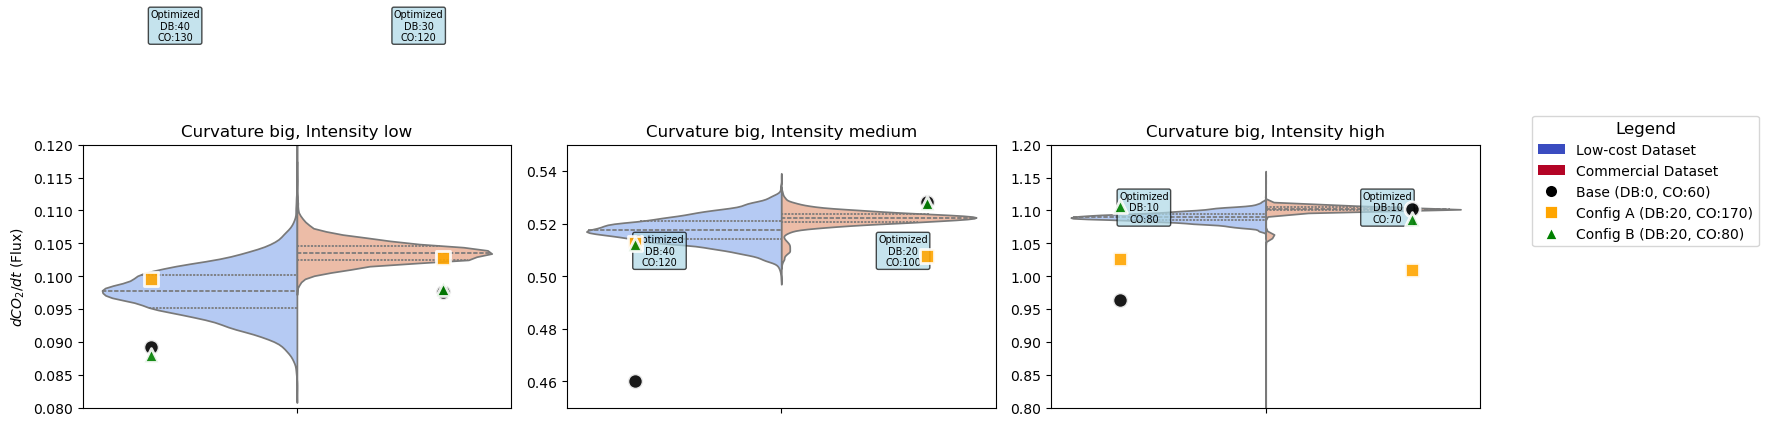

In [38]:
# Simpler enhancement to current approach - just modify cell 13
# This replaces the horizontal lines with better visual elements

datasets = [dsMC_low, dsMC_com]
datasets_types = ['Low-cost', 'Commercial']
colors = ['blue', 'red']

for curve in np.unique(expected_ds['curvature'].values):
    print()
    print(curve)
    cutoff_coords, deadband_coords = ds_base.coords['cutoff'], ds_base.coords['deadband']

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    yRange = [(0.08, 0.12), (0.45, 0.55), (0.8, 1.2)]
    
    for n, intensity in enumerate(['low', 'medium', 'high']):
        print(intensity)
        
        time_selection = expected_ds.where((expected_ds['curvature'] == curve) &
                                         (expected_ds['intensity_categories'] == intensity),
                                         drop=True).time.values
        print(time_selection)
        
        # Collect data for both datasets (same as before)
        df_boxplot = pd.DataFrame()
        
        for i, (dsMC, dataset_type) in enumerate(zip(datasets, datasets_types)):
            pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection).median(dim=['time']))
            Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange,flatNorm_logprob = pa.prepare_metrics()
            
            pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                y=flatNorm_logprob, 
                                                                maximize_x=False, maximize_y=False)
            best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob,
                                                                metric_x=Norm_uncertaintyRange,
                                                                metric_y=Norm_logprob)
            
            hist_dcdt = dsMC.sel(time=time_selection,
                                deadband=deadband_coords[best_pareto_y].values,
                                cutoff=cutoff_coords[best_pareto_x].values)['dcdt(HM)']
            
            temp_df = pd.DataFrame({
                'dcdt(HM)': hist_dcdt.median(dim='time').values.flatten(),
                'Dataset': dataset_type,
                'Deadband': deadband_coords[best_pareto_y].values,
                'Cutoff': cutoff_coords[best_pareto_x].values
            })
            df_boxplot = pd.concat([df_boxplot, temp_df], ignore_index=True)
            
        # Create violin plot - remove legend parameter to avoid individual legends
        sns.violinplot(data=df_boxplot, hue='Dataset', y='dcdt(HM)', split=True, 
                      palette='coolwarm', inner='quartiles', ax=ax[n], legend=False)
        
        # ENHANCED: Add arbitrary values as distinct visual elements
        arbitrary_configs = [
            {'deadband': 0, 'cutoff': 60, 'marker': 'o', 'size': 120, 'label': 'Base', 'color': 'black'},
            {'deadband': 20, 'cutoff': 170, 'marker': 's', 'size': 100, 'label': 'Config A', 'color': 'orange'},
            {'deadband': 20, 'cutoff': 80, 'marker': '^', 'size': 100, 'label': 'Config B', 'color': 'green'}
        ]
        
        # Add scatter points for arbitrary configurations
        x_positions = [-0.3, 0.3]  # Positions for Low-cost and Commercial
        
        for config in arbitrary_configs:
            for i, (dsMC, dataset_type) in enumerate(zip(datasets, datasets_types)):
                y_val = dsMC.sel(time=time_selection, 
                               deadband=config['deadband'], 
                               cutoff=config['cutoff'])['dcdt(HM)'].median().values
                
                ax[n].scatter(x_positions[i], y_val, 
                            marker=config['marker'], 
                            s=config['size'], 
                            c=config['color'], 
                            edgecolors='white', 
                            linewidth=2, 
                            alpha=0.9,
                            zorder=10)  # Ensure points appear on top
        
        # Add text labels for optimized parameters
        x_positions_text = [-0.25, 0.25]
        for i, dataset_type in enumerate(datasets_types):
            dataset_data = df_boxplot[df_boxplot['Dataset'] == dataset_type]
            if len(dataset_data) > 0:
                deadband_val = dataset_data['Deadband'].iloc[0]
                cutoff_val = dataset_data['Cutoff'].iloc[0]
                ax[n].text(x_positions_text[i], ax[n].get_ylim()[1] * 0.95, 
                          f'Optimized\nDB:{deadband_val:.0f}\nCO:{cutoff_val:.0f}', 
                          ha='center', va='top', fontsize=7,
                          bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.7))
        
        ax[n].set_title(f'Curvature {curve}, Intensity {intensity}')
        ax[n].set_ylim(yRange[n])
        ax[n].set_ylabel('$dCO_2/dt$ (Flux)' if n == 0 else '')
    
    # Create consolidated figure-level legend
    legend_elements = []
    
    # Add violin plot dataset legend elements
    from matplotlib.patches import Patch
    legend_elements.append(Patch(facecolor='#3A4CC0', label='Low-cost Dataset'))  # coolwarm blue
    legend_elements.append(Patch(facecolor='#B40426', label='Commercial Dataset'))  # coolwarm red
    
    # Add arbitrary configuration legend elements
    for config in arbitrary_configs:
        legend_elements.append(
            plt.Line2D([0], [0], marker=config['marker'], color='w', 
                      markerfacecolor=config['color'], markersize=10,
                      markeredgecolor='white', markeredgewidth=2,
                      label=f"{config['label']} (DB:{config['deadband']}, CO:{config['cutoff']})")
        )
    
    # Position legend outside the plot area
    fig.legend(handles=legend_elements, 
              loc='center left', 
              bbox_to_anchor=(1.02, 0.5),
              fontsize=10,
              title='Legend',
              title_fontsize=12)
    
    plt.tight_layout()
    plt.show()
    break  # Only show first curve